In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import cv2

# --- Data Loading and Feature Extraction ---
# (This part remains the same as before)

# Paths
base_dir = "lung"
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Val")
test_dir = os.path.join(base_dir, "Test")

# Image parameters
IMG_SIZE = (224, 224)  # Resize images to 224x224
BATCH_SIZE = 16

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Data loaders
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

val_data = val_datagen.flow_from_directory(
    val_dir, target_siz5tre=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

test_data = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# Load the MobileNet model pre-trained on ImageNet without the top layer (classification head)
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a GlobalAveragePooling2D layer to get the feature map
x = mobilenet.output
x = GlobalAveragePooling2D()(x)

# Create the model
feature_extractor = Model(inputs=mobilenet.input, outputs=x)

# Function to extract features
def extract_features(data_gen):
    features = []
    labels = []
    for batch in data_gen:
        # Extract features from the batch
        feature_batch = feature_extractor.predict(batch[0])
        features.append(feature_batch)
        labels.append(batch[1])
        # Stop if all data is processed
        if len(features) * BATCH_SIZE >= data_gen.samples:
            break
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

# Extract features from training, validation, and test data
train_features, train_labels = extract_features(train_data)
val_features, val_labels = extract_features(val_data)
test_features, test_labels = extract_features(test_data)


Found 11250 images belonging to 3 classes.
Found 1875 images belonging to 3 classes.
Found 1875 images belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━

In [2]:
# Print out the shapes of the extracted features
print(f"Train features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (11250, 1024)
Validation features shape: (1875, 1024)
Test features shape: (1875, 1024)


In [3]:
# Reshaping the feature data
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

In [4]:
# Encode labels as integers for classification models
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(np.argmax(train_labels, axis=1))  # One-hot to integer
val_labels = label_encoder.transform(np.argmax(val_labels, axis=1))
test_labels = label_encoder.transform(np.argmax(test_labels, axis=1))

Ensemble Model 1 ( SVM and Random Forest )

In [5]:
# --- Comparative Analysis ---

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# 1. SVM and Random Forest
svm_model = SVC(kernel='linear', probability=True)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

model1 = VotingClassifier(estimators=[('svm', svm_model), ('rf', rf_model)], voting='soft')
scores1 = cross_val_score(model1, train_features, train_labels, cv=cv, scoring='accuracy')



# Print cross-validation results of Model 1 (SVM + RF)
print(f"Cross-validation accuracy scores: {scores1}")
print(f"Model 1 (SVM + RF) - Mean CV Accuracy: {np.mean(scores1)}")
print(f"Standard deviation of CV accuracy: {np.std(scores1)}")



Cross-validation accuracy scores: [0.96177778 0.97422222 0.97111111 0.96133333 0.97422222]
Model 1 (SVM + RF) - Mean CV Accuracy: 0.9685333333333332
Standard deviation of CV accuracy: 0.005811185467975521


In [6]:
# Train the Model1 on the full training data
model1.fit(train_features, train_labels)

VotingClassifier(estimators=[('svm', SVC(kernel='linear', probability=True)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [7]:
# Evaluate on validation and test data instead of val_preds i have added 1 to know which model it is
val_preds1 = model1.predict(val_features)
test_preds1 = model1.predict(test_features)

class_names = [str(label) for label in label_encoder.classes_]


# Print classification report for validation and test sets
print("Validation Set Classification Report:")
print(classification_report(val_labels, val_preds1, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Validation Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.98      0.95      0.96       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.95      0.98      0.97       625

          accuracy                           0.98      1875
         macro avg       0.98      0.98      0.98      1875
      weighted avg       0.98      0.98      0.98      1875



In [8]:
#instead of val_preds i have added 1 to know which model it is
print("Test Set Classification Report:")
print(classification_report(test_labels, test_preds1, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Test Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.97      0.93      0.95       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.94      0.97      0.95       625

          accuracy                           0.97      1875
         macro avg       0.97      0.97      0.97      1875
      weighted avg       0.97      0.97      0.97      1875



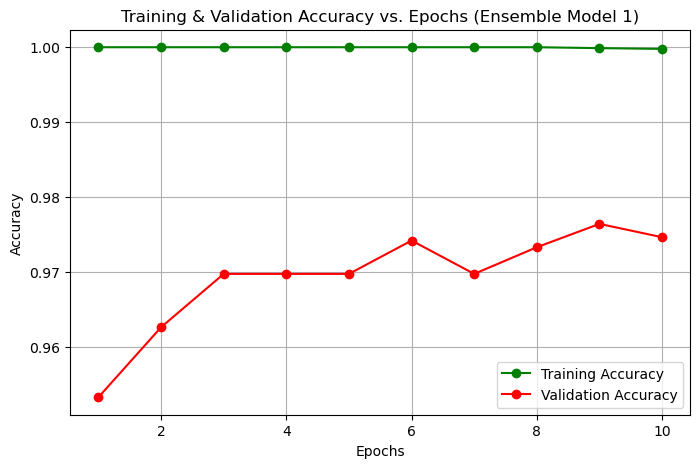

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into training and validation sets
X_train1, X_val1, y_train1, y_val1 = train_test_split(
    train_features, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Simulate training across epochs
epochs = np.arange(1, 11)
train_accuracies1 = []
val_accuracies1 = []

for epoch in epochs:
    # Ensure train_size is always < 1.0
    frac1 = min(epoch / len(epochs), 0.99)

    X_train_subset1, _, y_train_subset1, _ = train_test_split(
        X_train1, y_train1, train_size=frac1, stratify=y_train1, random_state=epoch
    )

    # Train model on this subset
    model1.fit(X_train_subset1, y_train_subset1)

    # Evaluate on training & validation sets
    train_acc = accuracy_score(y_train_subset1, model1.predict(X_train_subset1))
    val_acc = accuracy_score(y_val1, model1.predict(X_val1))

    train_accuracies1.append(train_acc)
    val_accuracies1.append(val_acc)

# Plot Training & Validation Accuracy with straight lines and points
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies1, 'go-', label="Training Accuracy")  # Green line with circles
plt.plot(epochs, val_accuracies1, 'ro-', label="Validation Accuracy")  # Red line with circles

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy vs. Epochs (Ensemble Model 1)")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Compute confusion matrix for validation and test sets
val_conf_matrix_model1 = confusion_matrix(val_labels, val_preds1)
test_conf_matrix_model1 = confusion_matrix(test_labels, test_preds1)

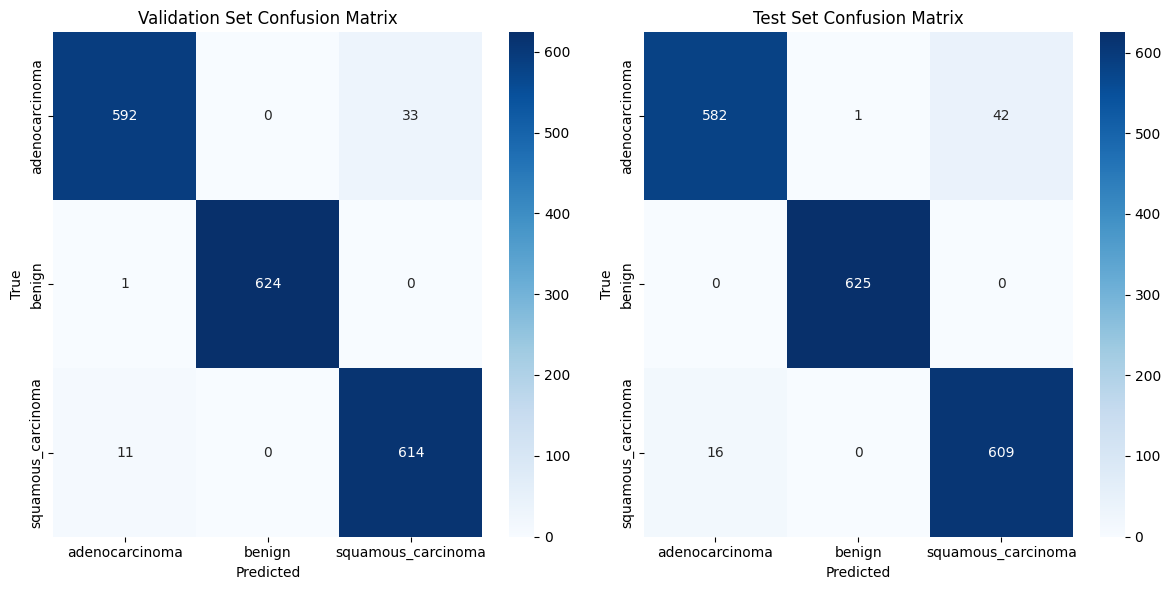

In [10]:

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Validation confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_conf_matrix_model1, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Test confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix_model1, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


Ensemble Model 2 ( Random Forest and Logistic Regression )

In [11]:



# 2. Random Forest and Logistic Regression
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

model2 = VotingClassifier(estimators=[('rf', rf_model), ('lr', lr_model)], voting='soft')
scores2 = cross_val_score(model2, train_features, train_labels, cv=cv, scoring='accuracy')


# Print cross-validation results of Model 2 (RF + LR)
print(f"Cross-validation accuracy scores: {scores2}")
print(f"Model 2 (RF + LR) - Mean CV Accuracy: {np.mean(scores2)}")
print(f"Standard deviation of CV accuracy: {np.std(scores2)}")



c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Cross-validation accuracy scores: [0.96622222 0.97288889 0.97422222 0.96622222 0.97644444]
Model 2 (RF + LR) - Mean CV Accuracy: 0.9712
Standard deviation of CV accuracy: 0.004220116433944621


c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# Train the Model 2 on the full training data
model2.fit(train_features, train_labels)

c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [ ]:
# Evaluate on validation and test data instead of val_preds i have added 2 to know which model it is
val_preds2 = model2.predict(val_features)
test_preds2 = model2.predict(test_features)

class_names = [str(label) for label in label_encoder.classes_]


# Print classification report for validation and test sets
print("Validation Set Classification Report:")
print(classification_report(val_labels, val_preds2, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Validation Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.98      0.95      0.97       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.95      0.98      0.97       625

          accuracy                           0.98      1875
         macro avg       0.98      0.98      0.98      1875
      weighted avg       0.98      0.98      0.98      1875



In [14]:
#instead of val_preds i have added 2 to know which model it is
print("Test Set Classification Report:")
print(classification_report(test_labels, test_preds2, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Test Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.97      0.93      0.95       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.94      0.98      0.96       625

          accuracy                           0.97      1875
         macro avg       0.97      0.97      0.97      1875
      weighted avg       0.97      0.97      0.97      1875



In [15]:
# Compute confusion matrix for validation and test sets
val_conf_matrix_model2 = confusion_matrix(val_labels, val_preds2)
test_conf_matrix_model2 = confusion_matrix(test_labels, test_preds2)

c:\Users\jeeva\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jeeva\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

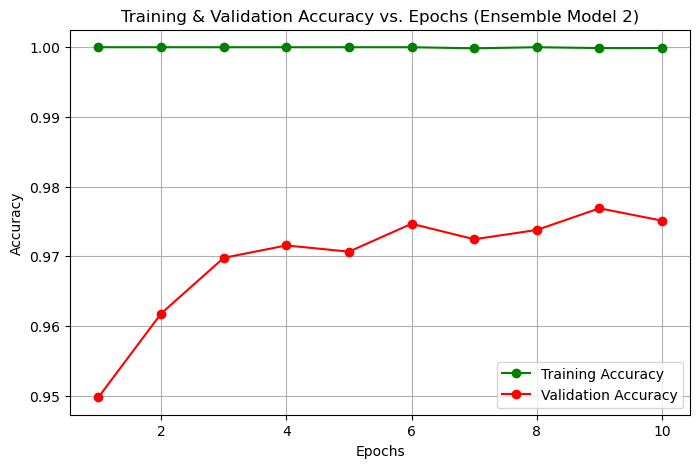

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Simulate training across epochs
epochs = np.arange(1, 11)
train_accuracies2 = []
val_accuracies2 = []

for epoch in epochs:
    # Ensure train_size is always < 1.0
    frac2 = min(epoch / len(epochs), 0.99)

    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train1, y_train, train_size=frac2, stratify=y_train, random_state=epoch
    )

    # Train model on this subset
    model2.fit(X_train_subset, y_train_subset)

    # Evaluate on training & validation sets
    train_acc = accuracy_score(y_train_subset, model2.predict(X_train_subset))
    val_acc = accuracy_score(y_val, model2.predict(X_val))

    train_accuracies2.append(train_acc)
    val_accuracies2.append(val_acc)

# Plot Training & Validation Accuracy with straight lines and points
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies2, 'go-', label="Training Accuracy")  # Green line with circles
plt.plot(epochs, val_accuracies2, 'ro-', label="Validation Accuracy")  # Red line with circles

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy vs. Epochs (Ensemble Model 2)")
plt.legend()
plt.grid(True)
plt.show()


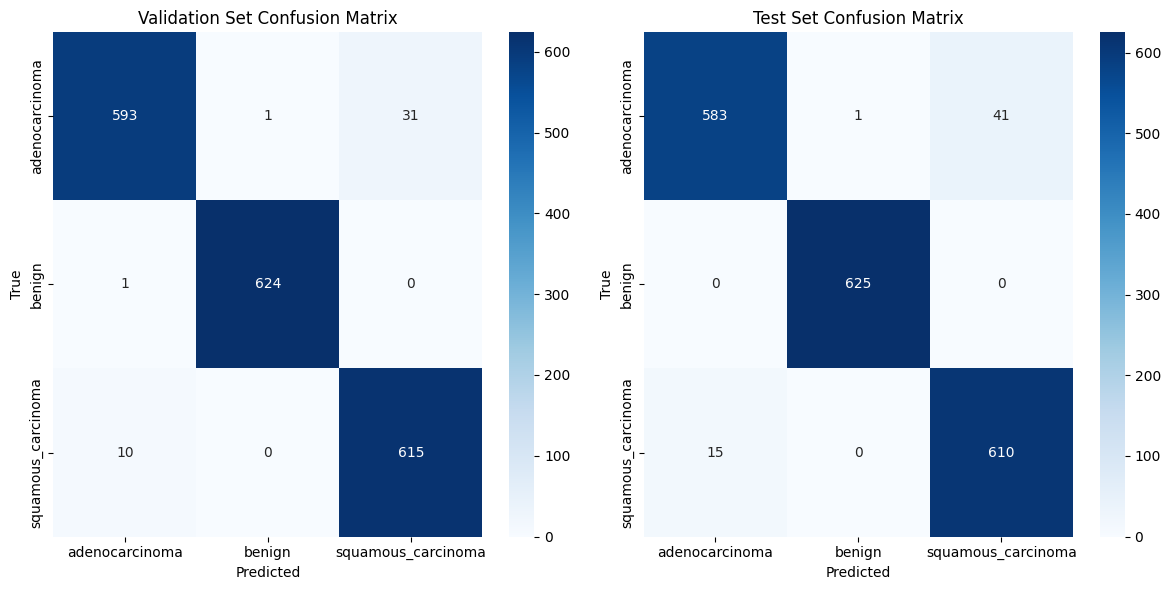

In [16]:

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Validation confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_conf_matrix_model2, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Test confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix_model2, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


Ensemble  Model 3 ( SVM and Logistic Regression )

In [17]:


# 3. SVM and Logistic Regression
svm_model = SVC(kernel='linear', probability=True)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

model3 = VotingClassifier(estimators=[('svm', svm_model), ('lr', lr_model)], voting='soft')
scores3 = cross_val_score(model3, train_features, train_labels, cv=cv, scoring='accuracy')



# Print cross-validation results of Model 2 (RF + LR)
print(f"Cross-validation accuracy scores: {scores3}")
print(f"Model 3 (RF + LR) - Mean CV Accuracy: {np.mean(scores3)}")
print(f"Standard deviation of CV accuracy: {np.std(scores3)}")



c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Cross-validation accuracy scores: [0.96266667 0.97288889 0.96888889 0.96222222 0.97511111]
Model 3 (RF + LR) - Mean CV Accuracy: 0.9683555555555555
Standard deviation of CV accuracy: 0.005224065868414282


In [18]:
# Train the Model 3 on the full training data
model3.fit(train_features, train_labels)

c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('svm', SVC(kernel='linear', probability=True)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [19]:
# Evaluate on validation and test data instead of val_preds i have added 3 to variable val_pred to know which model it is
val_preds3 = model3.predict(val_features)
test_preds3 = model3.predict(test_features)

class_names = [str(label) for label in label_encoder.classes_]


# Print classification report for validation and test sets
print("Validation Set Classification Report:")
print(classification_report(val_labels, val_preds3, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Validation Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.98      0.95      0.96       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.95      0.98      0.96       625

          accuracy                           0.97      1875
         macro avg       0.98      0.97      0.97      1875
      weighted avg       0.98      0.97      0.97      1875



In [20]:
#instead of val_preds i have added 3 to know which model it is
print("Test Set Classification Report:")
print(classification_report(test_labels, test_preds3, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Test Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.97      0.94      0.96       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.95      0.97      0.96       625

          accuracy                           0.97      1875
         macro avg       0.97      0.97      0.97      1875
      weighted avg       0.97      0.97      0.97      1875



c:\Users\jeeva\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jeeva\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

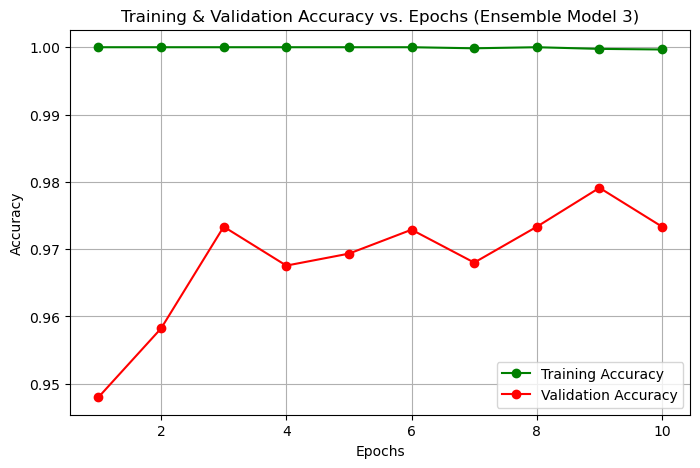

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Simulate training across epochs
epochs = np.arange(1, 11)
train_accuracies3 = []
val_accuracies3 = []

for epoch in epochs:
    # Ensure train_size is always < 1.0
    frac3 = min(epoch / len(epochs), 0.99)

    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train1, y_train, train_size=frac3, stratify=y_train, random_state=epoch
    )

    # Train model on this subset
    model3.fit(X_train_subset, y_train_subset)

    # Evaluate on training & validation sets
    train_acc = accuracy_score(y_train_subset, model3.predict(X_train_subset))
    val_acc = accuracy_score(y_val, model3.predict(X_val))

    train_accuracies3.append(train_acc)
    val_accuracies3.append(val_acc)

# Plot Training & Validation Accuracy with straight lines and points
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies3, 'go-', label="Training Accuracy")  # Green line with circles
plt.plot(epochs, val_accuracies3, 'ro-', label="Validation Accuracy")  # Red line with circles

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy vs. Epochs (Ensemble Model 3)")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Compute confusion matrix for validation and test sets
val_conf_matrix_model3 = confusion_matrix(val_labels, val_preds3)
test_conf_matrix_model3 = confusion_matrix(test_labels, test_preds3)

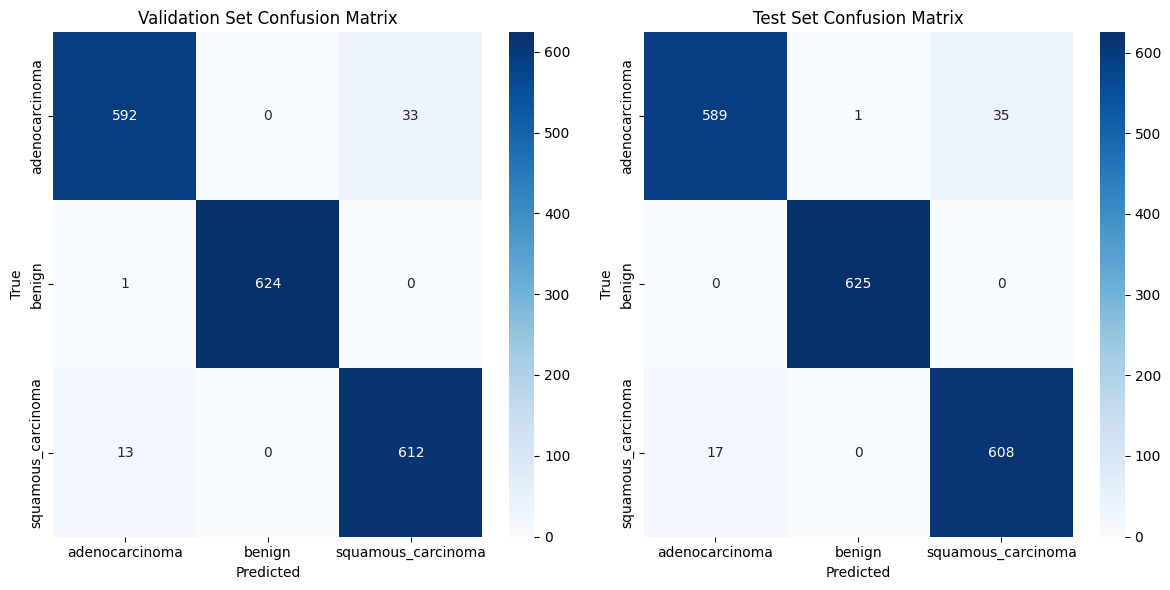

In [22]:

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Validation confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_conf_matrix_model3, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Test confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix_model3, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


Ensemble Model 4 (SVM , Random Forest and Logistic Regression)

In [23]:

# Model 4 (SVM + RF + LR )
svm_model = SVC(kernel='linear', probability=True)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Use it when showing error cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


model4 =VotingClassifier(estimators=[
    ('svm', svm_model),
    ('rf', rf_model),
    ('lr', lr_model)
], voting='soft')
scores4 = cross_val_score(model4, train_features, train_labels, cv=cv, scoring='accuracy')


# Print cross-validation results of Model 4 (SVM + RF + LR)
print("cross-validation results of Model 4 (SVM + RF + LR)")
print(f"Cross-validation accuracy scores: {scores4}")
print(f" Model 4 (SVM + RF + LR) - Mean CV Accuracy: {np.mean(scores4)}")
print(f"Standard deviation of CV accuracy: {np.std(scores4)}")


c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

cross-validation results of Model 4 (SVM + RF + LR)
Cross-validation accuracy scores: [0.96355556 0.97377778 0.97155556 0.964      0.976     ]
 Model 4 (SVM + RF + LR) - Mean CV Accuracy: 0.9697777777777776
Standard deviation of CV accuracy: 0.005098535253226642


In [24]:
# Train the Model4 on the full training data
model4.fit(train_features, train_labels)

c:\Users\0871\.conda\envs\new_python_3.10.14\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('svm', SVC(kernel='linear', probability=True)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [25]:
# Evaluate on validation and test data instead of val_preds i have added 4 to variable val_pred to know which model it is
val_preds4 = model4.predict(val_features)
test_preds4 = model4.predict(test_features)

class_names = [str(label) for label in label_encoder.classes_]


# Print classification report for validation and test sets
print("Validation Set Classification Report:")
print(classification_report(val_labels, val_preds4, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Validation Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.98      0.94      0.96       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.95      0.98      0.96       625

          accuracy                           0.97      1875
         macro avg       0.97      0.97      0.97      1875
      weighted avg       0.97      0.97      0.97      1875



In [26]:
#instead of val_preds i have added 4 to know which model it is
print("Test Set Classification Report:")
print(classification_report(test_labels, test_preds4, target_names=['adenocarcinoma', 'benign', 'squamous_carcinoma']))

Test Set Classification Report:
                    precision    recall  f1-score   support

    adenocarcinoma       0.98      0.94      0.96       625
            benign       1.00      1.00      1.00       625
squamous_carcinoma       0.94      0.98      0.96       625

          accuracy                           0.97      1875
         macro avg       0.97      0.97      0.97      1875
      weighted avg       0.97      0.97      0.97      1875



c:\Users\jeeva\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\jeeva\.conda\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

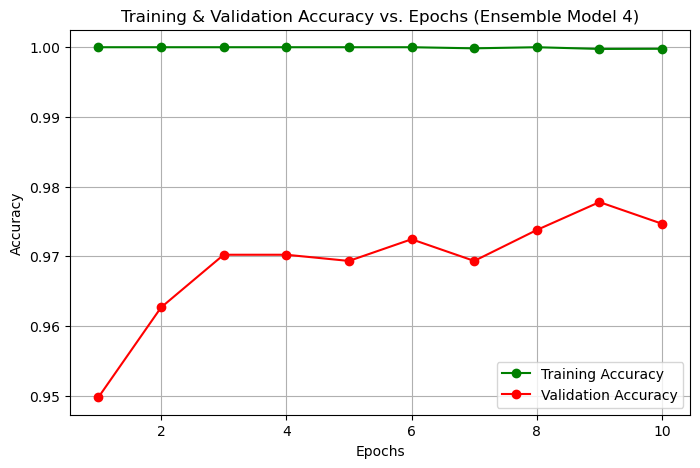

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_features, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# Simulate training across epochs
epochs = np.arange(1, 11)
train_accuracies4 = []
val_accuracies4 = []

for epoch in epochs:
    # Ensure train_size is always < 1.0
    frac4 = min(epoch / len(epochs), 0.99)

    X_train_subset, _, y_train_subset, _ = train_test_split(
        X_train1, y_train, train_size=frac4, stratify=y_train, random_state=epoch
    )

    # Train model on this subset
    model4.fit(X_train_subset, y_train_subset)

    # Evaluate on training & validation sets
    train_acc = accuracy_score(y_train_subset, model4.predict(X_train_subset))
    val_acc = accuracy_score(y_val, model4.predict(X_val))

    train_accuracies4.append(train_acc)
    val_accuracies4.append(val_acc)

# Plot Training & Validation Accuracy with straight lines and points
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracies4, 'go-', label="Training Accuracy")  # Green line with circles
plt.plot(epochs, val_accuracies4, 'ro-', label="Validation Accuracy")  # Red line with circles

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy vs. Epochs (Ensemble Model 4)")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Compute confusion matrix for validation and test sets
val_conf_matrix_model4 = confusion_matrix(val_labels, val_preds4)
test_conf_matrix_model4 = confusion_matrix(test_labels, test_preds4)

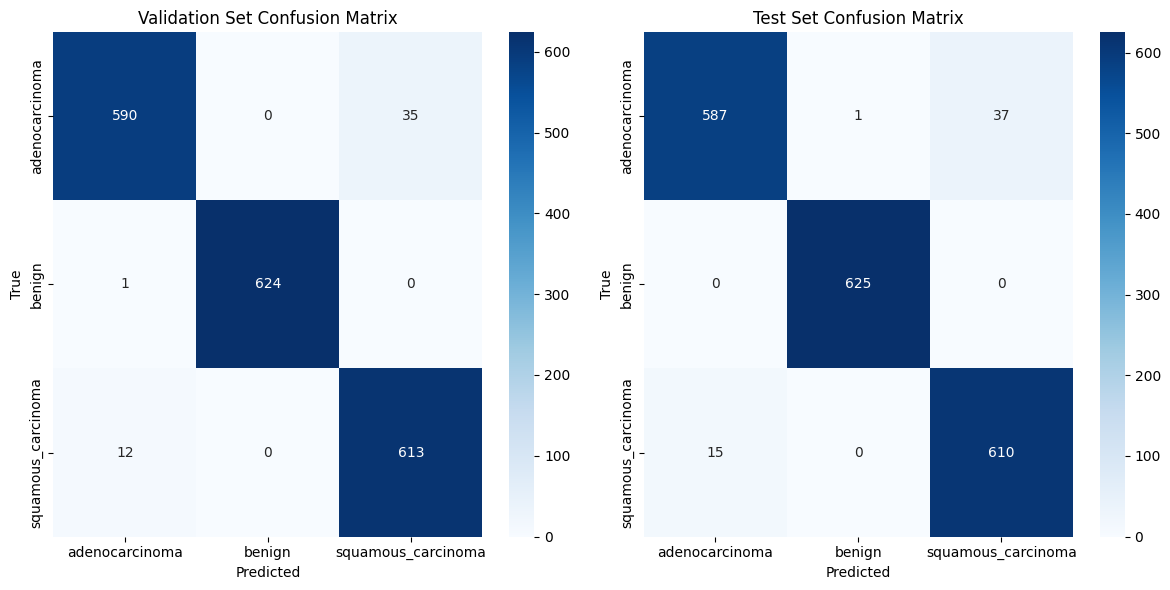

In [28]:

# Plot confusion matrices
plt.figure(figsize=(12, 6))

# Validation confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(val_conf_matrix_model4, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Test confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix_model4, annot=True, fmt='d', cmap='Blues', xticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'], yticklabels=['adenocarcinoma', 'benign', 'squamous_carcinoma'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


Model Selection and Evaluation

In [29]:
# --- Model Selection and Evaluation ---
# Compare mean accuracy scores and select the best model

best_model = model1  # Initialize with the first model
best_score = np.mean(scores1)

if np.mean(scores2) > best_score:
    best_model = model2
    best_score = np.mean(scores2)

if np.mean(scores3) > best_score:
    best_model = model3
    best_score = np.mean(scores3)

if np.mean(scores4) > best_score:  # New condition for Model 4
    best_model = model4
    best_score = np.mean(scores4)

print(f"\nBest Model: {best_model}")
print(f"Best Mean CV Accuracy: {best_score:.4f}")



Best Model: VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')
Best Mean CV Accuracy: 0.9712


In [ ]:

import statistics

print(max(statistics.mean(val_accuracies1),statistics.mean(val_accuracies2),statistics.mean(val_accuracies3),statistics.mean(val_accuracies4)))

0.9696444444444444


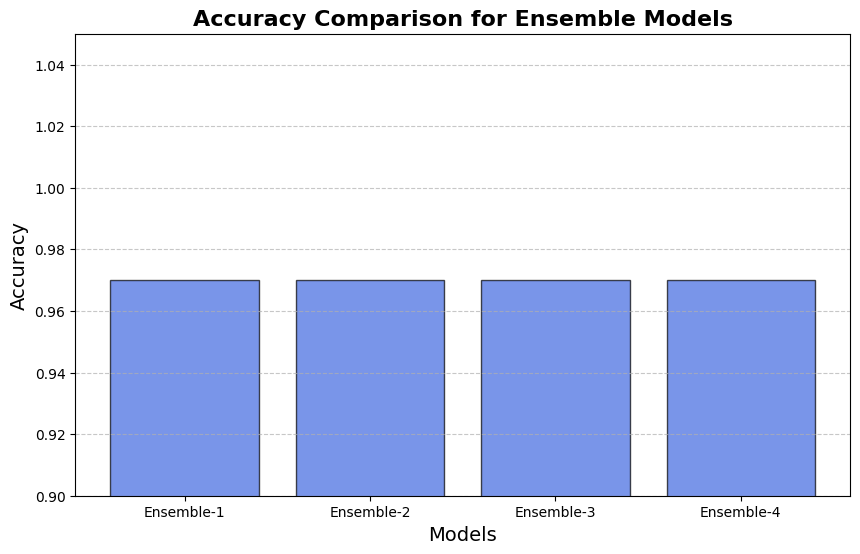

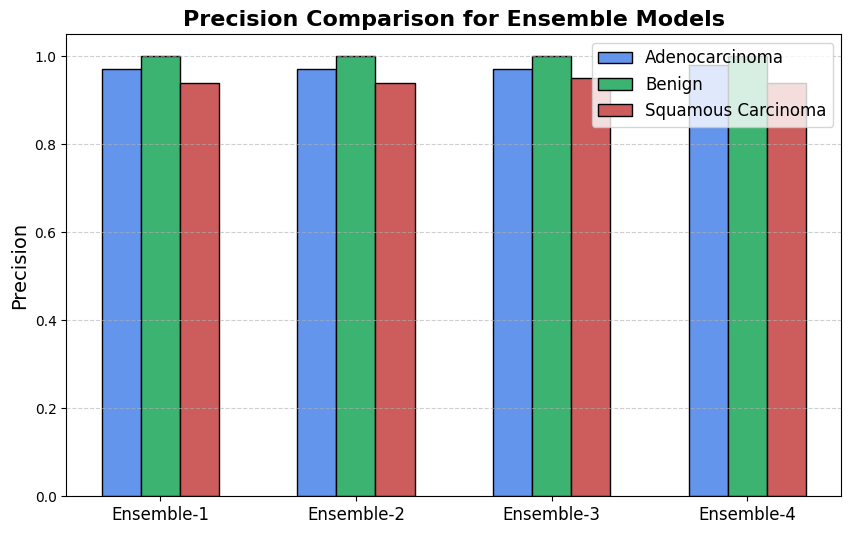

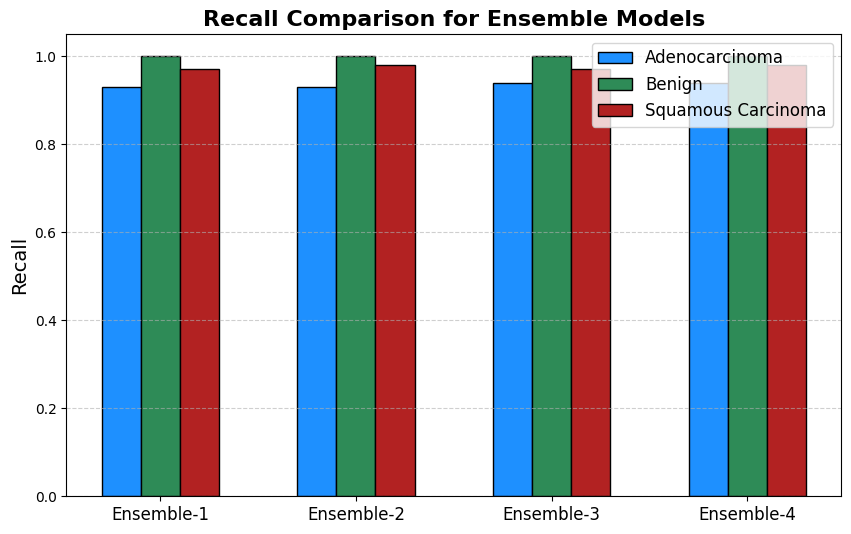

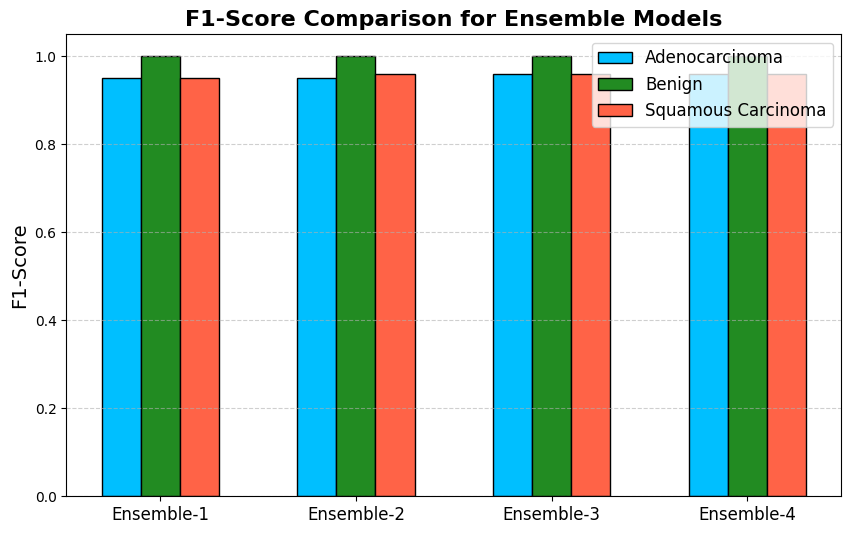

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Ensemble-1', 'Ensemble-2', 'Ensemble-3', 'Ensemble-4']

# Accuracy values
accuracy = [0.97, 0.97, 0.97, 0.97]

# Precision values
precision_adenocarcinoma = [0.97, 0.97, 0.97, 0.98]
precision_benign = [1.00, 1.00, 1.00, 1.00]
precision_squamous = [0.94, 0.94, 0.95, 0.94]

# Recall values
recall_adenocarcinoma = [0.93, 0.93, 0.94, 0.94]
recall_benign = [1.00, 1.00, 1.00, 1.00]
recall_squamous = [0.97, 0.98, 0.97, 0.98]

# F1-score values
f1_adenocarcinoma = [0.95, 0.95, 0.96, 0.96]
f1_benign = [1.00, 1.00, 1.00, 1.00]
f1_squamous = [0.95, 0.96, 0.96, 0.96]

x = np.arange(len(models))
width = 0.2

def plot_bar_chart(values1, values2, values3, ylabel, title, colors, save_as):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width, values1, width, label='Adenocarcinoma', color=colors[0], edgecolor='black')
    ax.bar(x, values2, width, label='Benign', color=colors[1], edgecolor='black')
    ax.bar(x + width, values3, width, label='Squamous Carcinoma', color=colors[2], edgecolor='black')

    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=12)
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.savefig(save_as, dpi=300, bbox_inches='tight')
    plt.show()

# Accuracy Plot
plt.figure(figsize=(10, 6))
plt.bar(models, accuracy, color='royalblue', edgecolor='black', alpha=0.7)
plt.title('Accuracy Comparison for Ensemble Models', fontsize=16, fontweight='bold')
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.9, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision Plot
plot_bar_chart(precision_adenocarcinoma, precision_benign, precision_squamous,
               'Precision', 'Precision Comparison for Ensemble Models',
               ['cornflowerblue', 'mediumseagreen', 'indianred'], "precision_comparison.png")

# Recall Plot
plot_bar_chart(recall_adenocarcinoma, recall_benign, recall_squamous,
               'Recall', 'Recall Comparison for Ensemble Models',
               ['dodgerblue', 'seagreen', 'firebrick'], "recall_comparison.png")

# F1-Score Plot
plot_bar_chart(f1_adenocarcinoma, f1_benign, f1_squamous,
               'F1-Score', 'F1-Score Comparison for Ensemble Models',
               ['deepskyblue', 'forestgreen', 'tomato'], "f1score_comparison.png")


Saving & Loading Best Model)

In [30]:
import joblib
from tensorflow.keras.models import load_model

# Save the trained best model
joblib.dump(best_model, 'best_model.joblib')

# Load the saved best model
best_model = joblib.load('best_model.joblib')

In [31]:
# Save the feature extraction model
feature_extractor.save('feature_extractor_model.h5')

# Load the saved feature extraction model
feature_extractor = load_model('feature_extractor_model.h5')

Prediction on a Single Image

In [ ]:
class_names = ['adenocarcinoma', 'benign', 'squamous_carcinoma']
def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_resized = cv2.resize(img, target_size)  # Resize image
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension
    img_resized = img_resized / 255.0  # Normalize
    return img_resized

# Function to extract features from a single image
def extract_features_from_image(img_path):
    img_preprocessed = preprocess_image(img_path)
    features = feature_extractor.predict(img_preprocessed)
    return features

# Make a prediction on a single image
def predict_image(img_path):
    # Extract features from the image
    features = extract_features_from_image(img_path)
    features = features.reshape(1, -1)  # Flatten the feature map

    # Predict using the ensemble model
    prediction = best_model.predict(features) # Use best_model

    return prediction

# Path to the image you want to predict
image_path = r'lung/Test/squamous_carcinoma/lungscc4377.jpeg'  # Replace with your image path

# Predict the image
prediction = predict_image(image_path)

# Get class label and class name
predicted_label = prediction[0]
predicted_class_name = class_names[predicted_label]

# Output the predicted class name
print(f"Predicted class label: {predicted_label} ({predicted_class_name})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Predicted class label: 2 (squamous_carcinoma)
